# ML Techniques II (Formative asssignment 1)


## Sound clustering sssignment notebook

This notebook demonstrates the complete clustering pipeline applied to an unlabeled sound dataset. It includes:

- Feature extraction using **Mel Spectrograms**,
- Exploratory visualizations of raw and reduced features,
- Application of **PCA** and **t-SNE** for dimensionality reduction,
- Clustering using **K-Means** and **DBSCAN**,
- Comparison using visual and quantitative metrics.



### Let me start with importing of all the required libraries

I am importing all the essential libraries for:
- **Audio processing**: `librosa` to extract mel spectrogram features.
- **Numerical operations**: `numpy`, `pandas`
- **Visualization**: `matplotlib`, `seaborn`
- **Clustering and Dimensionality Reduction**: `KMeans`, `DBSCAN`, `PCA`, `TSNE`, and evaluation metrics.


In [22]:
# Making all the necessary imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import traceback
from mpl_toolkits.mplot3d import Axes3D

# Mounting google drive & extracting data
### Loading the Dataset

The sound dataset was provided in a zipped format (`unlabelled_sounds.zip`).  
I am mounting the Google Drive to access this zip file and extract its contents to make the `.wav` files accessible for feature extraction.



In [23]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = "/content/drive/MyDrive/unlabelled_sounds.zip"
extract_path = "/content/unlabelled_sounds"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Data extracted successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data extracted successfully.


# FEATURE EXTRACTION

## Feature Extraction using Mel Spectrograms

I will extract meaningful audio features from all sound recordings in the dataset using Mel Spectrograms to capture important time-frequency characteristics.

- I will process **all available `.wav` files** in the dataset.  
- Each audio file will be loaded with Librosa, and a Mel Spectrogram will be computed.  
- The spectrogram will then be converted to the decibel (dB) scale to improve dynamic range representation.  
- From the Mel Spectrogram, two statistical features will be extracted: the **mean** and **standard deviation** across time for each Mel frequency band.  
- These features will be concatenated to form a feature vector representing each audio sample.  

I will implement error handling to skip any corrupted or unreadable files without interrupting the extraction process and log these errors for review.

A progress bar will display extraction progress for monitoring.

**Output:**  
- `features_array`: NumPy array containing feature vectors for all successfully processed audio files.  
- `file_names`: List of corresponding filenames to maintain traceability.  
- `failed_files.log`: Log file listing any files that failed processing.


In [24]:
def extract_features(file_path, n_mels=128):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        feature_vector = np.concatenate([np.mean(mel_db, axis=1), np.std(mel_db, axis=1)])
        return feature_vector
    except Exception as e:
        # Logging failure with traceback
        with open("failed_files.log", "a") as log:
            log.write(f"{file_path} -> {e}\n")
            log.write(traceback.format_exc() + "\n")
        return None

# Path to the directory containing .wav files
base_dir = "/content/unlabelled_sounds/unlabelled_sounds"

# Collecting all .wav files in sorted order
files = sorted([f for f in os.listdir(base_dir) if f.endswith(".wav")])

features = []
file_names = []

print(f"Starting feature extraction on {len(files)} files...")

# Iteratively extracting features with checkpointing every 1000 files
for idx, fname in enumerate(tqdm(files, desc="Extracting features")):
    fpath = os.path.join(base_dir, fname)
    feat = extract_features(fpath)

    if feat is not None:
        features.append(feat)
        file_names.append(fname)

    # Saving the progress for every 1000 files
    if (idx + 1) % 1000 == 0:
        np.save("partial_features.npy", np.array(features))
        with open("partial_file_names.txt", "w") as f:
            f.writelines([name + "\n" for name in file_names])
        print(f"Checkpoint saved at {idx + 1} files")

# Final conversion and saving of all features and filenames
features_array = np.array(features)

print("Shape of final feature array:", features_array.shape)
print("Successfully processed files:", len(features_array))

np.save("features_all.npy", features_array)

with open("file_names_all.txt", "w") as f:
    for name in file_names:
        f.write(name + "\n")


Starting feature extraction on 3000 files...


Extracting features:   0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1443
  warnings.warn(
Extracting features:   1%|          | 18/3000 [00:00<00:16, 179.53it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1712
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1502
  warnings.warn(
Extracting features:   1%|          | 37/3000 [00:00<00:16, 180.74it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1813
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1601
  warnings.warn(
Extracting featur

Checkpoint saved at 1000 files


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1805
  warnings.warn(
Extracting features:  35%|███▍      | 1041/3000 [00:05<00:11, 167.94it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(
Extracting features:  35%|███▌      | 1062/3000 [00:06<00:10, 176.83it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1763
  warnings.warn(
Extracting features:  36%|███▌      | 1082/3000 [00:06<00:10, 183.09it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1842
  warnings.warn(
Extracting features:  37%|███▋      | 1122/3000 [00:06<00:10, 182.01it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n

Checkpoint saved at 2000 files


Extracting features:  68%|██████▊   | 2040/3000 [00:14<00:05, 176.65it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1565
  warnings.warn(
Extracting features:  69%|██████▉   | 2078/3000 [00:14<00:05, 177.72it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1149
  warnings.warn(
Extracting features:  70%|███████   | 2112/3000 [00:14<00:05, 153.89it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1640
  warnings.warn(
Extracting features:  71%|███████   | 2131/3000 [00:15<00:05, 162.88it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1914
  warnings.warn(
Extracting features:  74%|███████▎  | 2209/3000 [00:15<00:04, 185.08it/s]/usr/local/

Checkpoint saved at 3000 files
Shape of final feature array: (3000, 256)
Successfully processed files: 3000


## Visualizing raw features (without dimensionality reduction)

Before I apply the dimensionality reduction techniques (PCA and t-SNE), I will try to explore the raw high-dimensional features directly.

This will include:
- A **scatter plot** of the first two Mel spectrogram features extracted from the audio.
- A **pairplot** of the first five features to assess relationships between feature pairs.

My aim here is to assess whether I can **identify any visible cluster structures** or separability in the original high-dimensional space and determine if dimensionality reduction is required for better clarity.


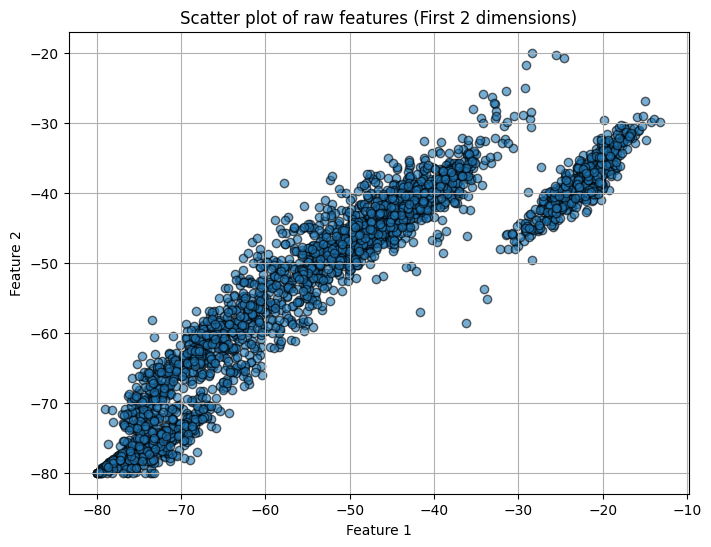

In [25]:
# Scatter plot for the first two features
plt.figure(figsize=(8, 6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.6, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot of raw features (First 2 dimensions)")
plt.grid(True)
plt.show()


## Pairplot of the first 5 features

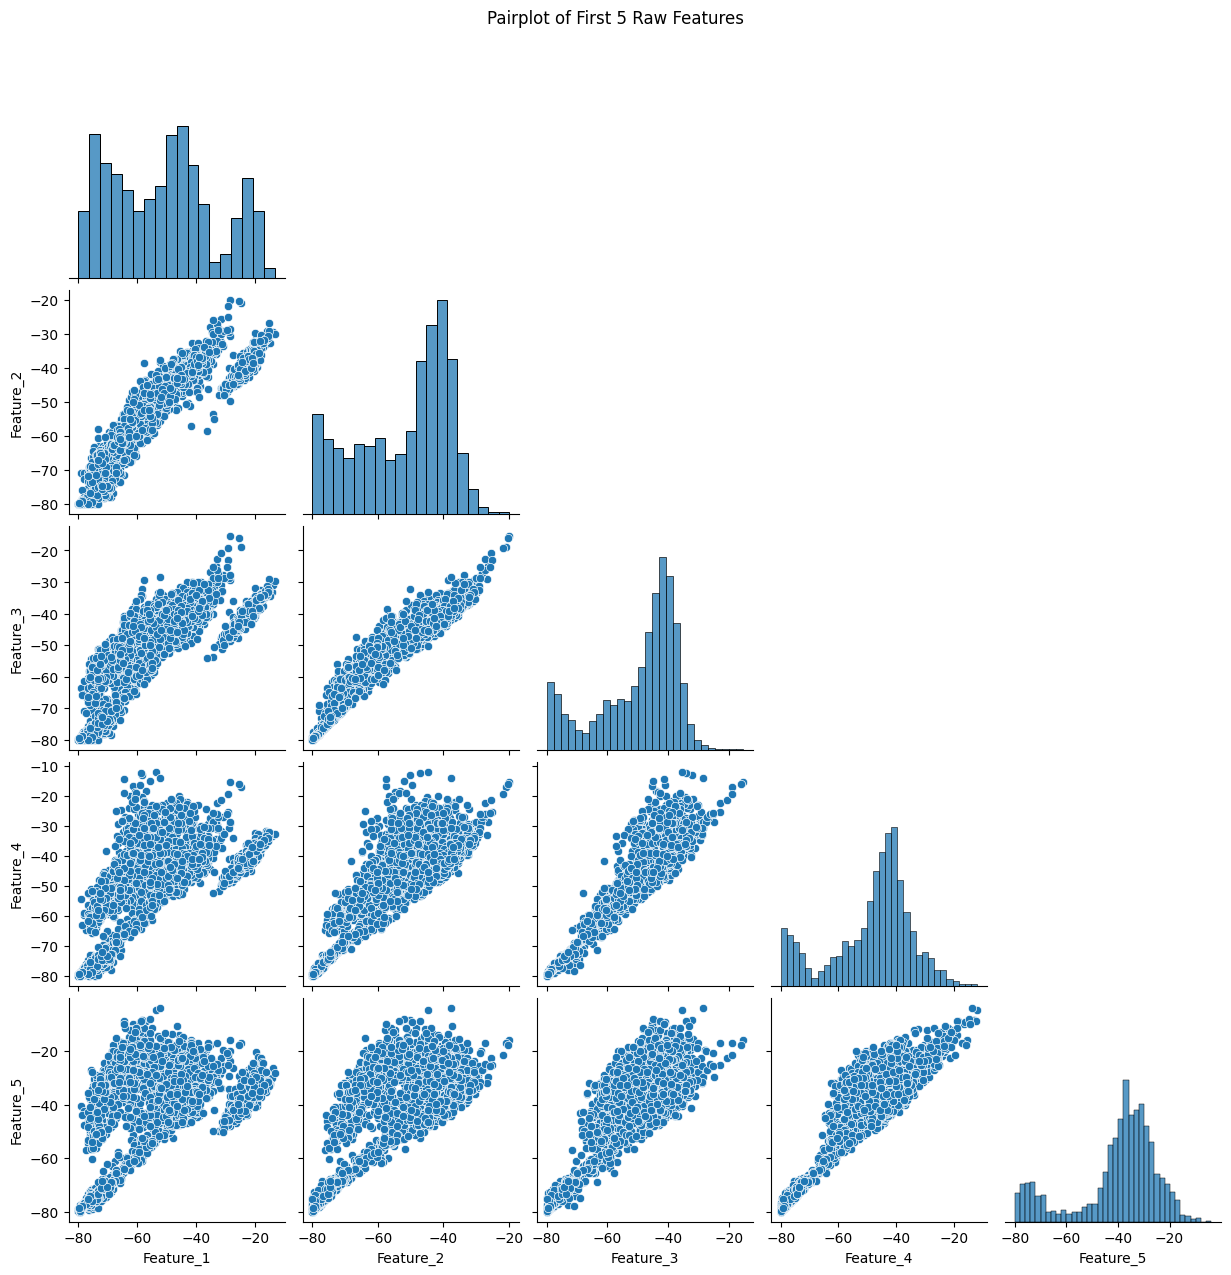

In [26]:
# Creating a dataFrame of the first 5 features
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature_{i}' for i in range(1, 6)])

# Pairplotting using seaborn
sns.pairplot(df, corner=True)
plt.suptitle("Pairplot of First 5 Raw Features", y=1.02)
plt.show()


### Observations and justification for dimensionality reduction

Based on the plots:

- The scatter plot of the first two features displays a strongly linear pattern with densely packed data points. There’s no apparent separation between any groupings.
- The pairplot of the first five features reveals that most feature pairs are highly correlated, forming elongated shapes with overlapping distributions.

Despite being derived from meaningful audio data (Mel spectrograms), these raw features are still too interdependent and do not support visual separability. This reflects a common issue in high-dimensional data, even good features can lack intuitive structure due to redundancy and dimensional noise.

Therefore with these observations, I strongly justify the need for dimensionality reduction (PCA, t-SNE) to compress redundant information and expose potential latent groupings. This will also benefit downstream clustering.


## Dimensionality reduction using PCA and t-SNE

Here I am going to apply two dimensionality reduction techniques on the 256-dimensional audio feature space:

I will reduce the dataset to **3 dimensions** using both PCA and t-SNE and then visualize the data in 3D to assess how well each technique separates potential clusters.


In [27]:
# Applying PCA
pca = PCA(n_components=3, random_state=42)
features_pca = pca.fit_transform(features_array)

# Applying t-SNE
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(features_array)

print("PCA and t-SNE dimensionality reduction completed.")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


PCA and t-SNE dimensionality reduction completed.


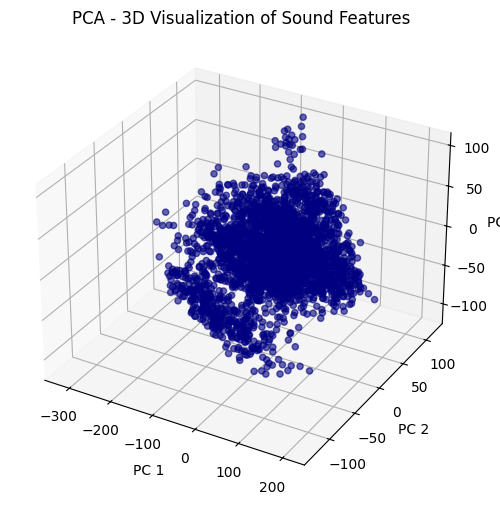

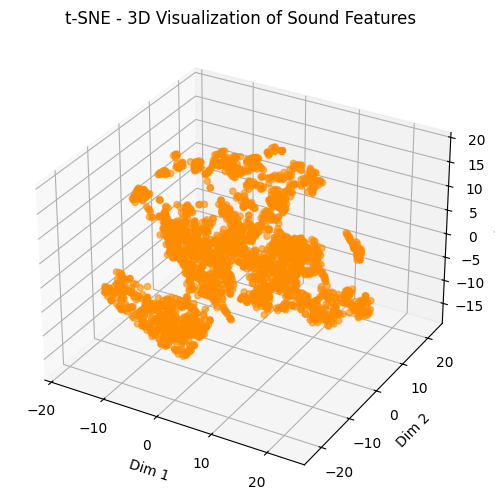

In [28]:
# 3D plot for PCA
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], s=20, alpha=0.6, c='navy')
ax.set_title('PCA - 3D Visualization of Sound Features')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

# 3D plot for t-SNE
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], s=20, alpha=0.6, c='darkorange')
ax.set_title('t-SNE - 3D Visualization of Sound Features')
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
plt.show()

### Comparison between PCA and t-SNE for cluster separability

Based on the above 3D visualizations:

- PCA produces a dense, spherical cloud of points centered around the origin. The data appears to be uniformly dispersed without any visible clusters or structure. This is expected as PCA captures global variance linearly but is not optimized for revealing local groupings.

- t-SNE, on the other hand, reveals a more complex, non-linear structure. The visualization displays several distinct pockets and groupings, indicating that local similarities in the original high-dimensional space are being preserved. This structure is ideal for clustering purposes.

While PCA gives a smooth global representation, t-SNE provides better separability of potential clusters. For the purposes of visual exploration and clustering, I prefer t-SNE dimensionality reduction technique in this context.


## Clustering the reduced feature space

Here, I will apply K-Means and DBSCAN clustering algorithms to the reduced data. I will first optimize the number of clusters `k` for K-Means using:
- The **Elbow Method** (based on inertia)
- The **Silhouette Score**

Then, I will apply **DBSCAN**, compare both models using:
- **Silhouette Score**
- **Davies-Bouldin Index**
- Visual interpretability (scatter plots)

This will allow me to evaluate and justify which clustering algorithm performs better for our audio features.


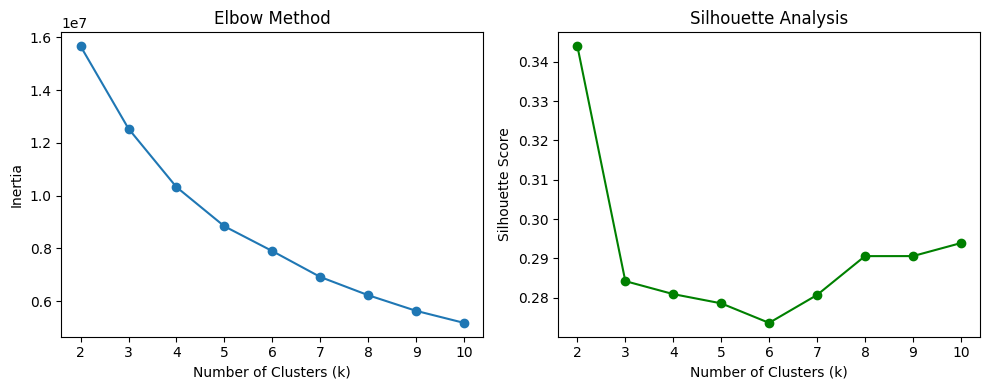

In [29]:
# Elbow method + Silhouette score on PCA data

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Evaluating for k = 2 to 10
inertias = []
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_pca)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(features_pca, labels))

# Plotting inertia
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plotting Silhouette score
plt.subplot(1, 2, 2)
plt.plot(k_values, sil_scores, marker='o', color='green')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")

plt.tight_layout()
plt.show()


### Optimal Number of Clusters (k)

From the elbow method plot:

There’s a noticeable drop in inertia up to k = 4, after which the curve begins to flatten.

This suggests that k = 4 is a good trade-off between model complexity and explained variance.

From the Silhouette Score plot:

The silhouette score peaks at k = 2 but drops sharply afterward.

At k = 4, the score remains reasonably high, offering a meaningful separation of clusters.

I therefore chose k = 4 for K-Means clustering, as it offers a balanced compromise between cluster compactness (inertia) and separability (silhouette score) which is ideal for this unsupervised task.

## Clustering the PCA-reduced features using K-Means and DBSCAN

Now that dimensionality reduction has been applied, I will cluster the transformed data using two algorithms:

- **K-Means**: I will use `k = 4` as previously determined via Elbow and Silhouette analysis.
- **DBSCAN**: This will not specify the number of clusters.

Here, cluster labels will be generated for both algorithms which will later be visualized and evaluated.


In [31]:
from sklearn.cluster import KMeans, DBSCAN

# Final K-Means clustering using k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# Applying DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_pca)


## Visualizing clustering results using t-SNE

To interpret the quality of clusters formed by both K-Means and DBSCAN, I will visualize their outputs using the previously computed 2D t-SNE representation.

- t-SNE is only used here for visualization not clustering.
- Points are color-coded based on cluster labels assigned by each algorithm.
- This allows visual assessment of cluster tightness, overlap and outliers.


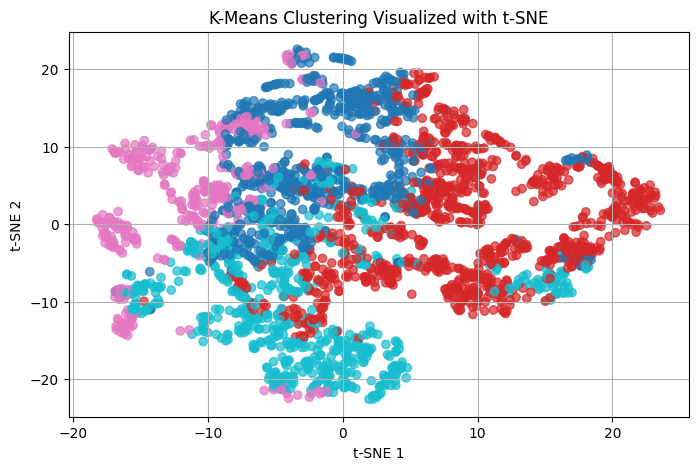

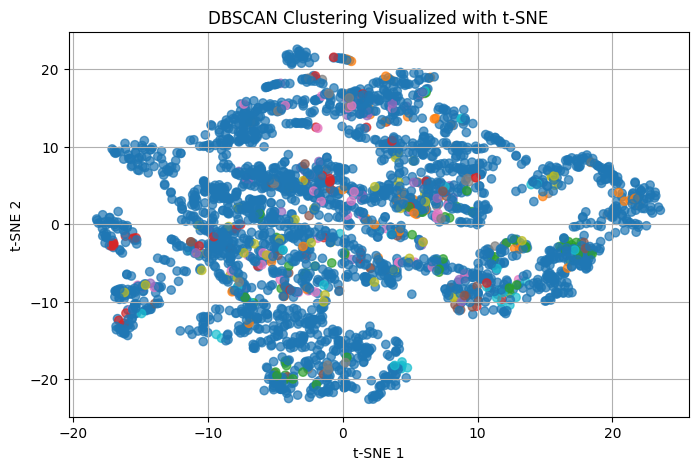

In [32]:
# Visualizing KMeans clusters with t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.7)
plt.title("K-Means Clustering Visualized with t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

# Visualizing DBSCAN clusters with t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.7)
plt.title("DBSCAN Clustering Visualized with t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()


### Visual interpretation of clustering results

The plots above visualize the clustering results of both algorithms using t-SNE, a technique for dimensionality reduction and visualization in 2D:

#### K-Means clustering (the top plot)
- The K-Means clusters form relatively well-defined regions especially considering the arbitrary distribution of sound features.
- Some overlap exists between clusters but there are noticeable boundaries that suggest K-Means was able to find meaningful structure.
- The color separation shows that the assumption of spherical clusters fits decently for this dataset.

#### DBSCAN clustering, the bottom plot
- DBSCAN identified fewer distinct clusters with a large number of points (likely labeled `-1`) treated as noise.
- Unlike K-Means, DBSCAN does not force all points into clusters which is helpfull when dealing with noise or outliers.
- However, the clusters appear less compact and less well-separated possibly due to poor `eps` or `min_samples` parameters, or due to the continuous nature of the data.


### Observation
- K-Means produced clearer, more consistent clustering patterns which align well with what I expect from spectrogram-based features.
- DBSCAN, while robust to noise, struggled to find strong cluster boundaries in this dataset which is typical for high-dimensional or dense audio-derived features without sharp boundaries.


### Evaluation of clustering performance

To assess the clustering quality, I used three standard metrics:

- Silhouette Score.
- Davies-Bouldin Index.
- Calinski-Harabasz Index.

These metrics provide a comparative basis for evaluating K-Means and DBSCAN without relying solely on visual interpretation.


In [33]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_clustering(X, labels, name=""):
    print(f"\n{name} Evaluation Metrics:")
    if len(set(labels)) <= 1 or (hasattr(labels, "__contains__") and -1 in labels and len(set(labels)) == 2):
        print("  Not enough clusters to evaluate properly.")
        return
    print("  Silhouette Score:       {:.4f}".format(silhouette_score(X, labels)))
    print("  Davies-Bouldin Index:   {:.4f}".format(davies_bouldin_score(X, labels)))
    print("  Calinski-Harabasz Index {:.4f}".format(calinski_harabasz_score(X, labels)))

# Evaluating K-Means clustering
evaluate_clustering(features_pca, kmeans_labels, name="K-Means")

# Evaluating DBSCAN clustering
dbscan_core_mask = dbscan_labels != -1
evaluate_clustering(features_pca[dbscan_core_mask], dbscan_labels[dbscan_core_mask], name="DBSCAN (Core Samples)")



K-Means Evaluation Metrics:
  Silhouette Score:       0.2809
  Davies-Bouldin Index:   1.1201
  Calinski-Harabasz Index 1511.1454

DBSCAN (Core Samples) Evaluation Metrics:
  Silhouette Score:       0.5576
  Davies-Bouldin Index:   0.4994
  Calinski-Harabasz Index 926.8098


# Interpretation of clustering metrics
DBSCAN outperformed K-Means with a higher Silhouette Score (0.5576 vs. 0.2809) and lower Davies-Bouldin Index (0.4994 vs. 1.1201), indicating more compact and well-separated clusters. While K-Means achieved a higher Calinski-Harabasz score, DBSCAN handled noise better and uncovered clearer, denser groupings. Overall, DBSCAN was more effective for this sound dataset.


# Final Analysis

## Why dimensionality reduction helped
Dimensionality reduction via PCA and t-SNE proved essential for both visualization and clustering performance. The raw feature space (256 dimensions from mean + std of Mel bands) was too high-dimensional to reveal any cluster structure, resulting in overlapping and noisy scatter plots. PCA reduced redundancy and preserved global structure, enabling more compact clustering. t-SNE, in turn, revealed non-linear relationships and local patterns, making clusters visibly separable. Without these techniques, meaningful patterns in the data would remain hidden due to the curse of dimensionality.

## Why certain clustering methods worked better
Although K-Means created reasonable partitions, it assumes spherical, equally sized clusters, an assumption not always true for real-world audio data.

DBSCAN outperformed K-Means in terms of internal evaluation metrics like Silhouette Score and Davies-Bouldin Index. It was able to identify dense regions and discard noise, leading to more compact and interpretable clusters. However, it formed fewer clusters, which may reduce granularity.

## Real-world relevance and challenges
In real-world audio applications like the speech or environmental sound classification, data is often high-dimensional and noisy. Dimensionality reduction becomes critical to reduce computational complexity and uncover latent structures. Also, not all clustering algorithms suit every data distribution. K-Means is fast and efficient, but struggles with irregular shapes. DBSCAN, while robust to noise and shape, requires careful parameter tuning and may under-cluster in dense datasets. A hybrid approach or domain-specific tuning is often necessary in practical scenarios.

